In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


c:\Users\aviru\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\aviru\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\aviru\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [2]:
base_path = "processed_signature/processed"
csv_path = os.path.join(base_path, "signature_dataset.csv")

df = pd.read_csv(csv_path)

print(df.head())
print("Total Samples:", len(df))


             image_path  person_id  label  split
0  train/031/05_031.png         31      0  train
1  train/031/07_031.png         31      0  train
2  train/031/11_031.png         31      0  train
3  train/031/08_031.png         31      0  train
4  train/031/12_031.png         31      0  train
Total Samples: 2149


In [3]:
#Split Train - Test

train_df = df[df['image_path'].str.contains('train')]
test_df  = df[df['image_path'].str.contains('test')]

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))


Train samples: 1649
Test samples: 500


In [4]:
#image genarators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
#Create Data Generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=base_path,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    class_mode="raw",
    batch_size=16
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=base_path,
    x_col="image_path",
    y_col="label",
    target_size=(224,224),
    class_mode="raw",
    batch_size=16,
    shuffle=False
)


Found 1649 validated image filenames.
Found 500 validated image filenames.


In [6]:
#Bulid ResNet50 Model

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
# Train Model

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


c:\Users\aviru\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5841 - loss: 0.6732

c:\Users\aviru\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.6022 - loss: 0.6757 - val_accuracy: 0.6220 - val_loss: 0.6329
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6592 - loss: 0.6156 - val_accuracy: 0.6900 - val_loss: 0.5735
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.6628 - loss: 0.6020 - val_accuracy: 0.6340 - val_loss: 0.6225
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.6877 - loss: 0.5783 - val_accuracy: 0.7420 - val_loss: 0.5374
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.7077 - loss: 0.5610 - val_accuracy: 0.6680 - val_loss: 0.6001
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7259 - loss: 0.5331 - val_accuracy: 0.6020 - val_loss: 0.7021
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.7241 - loss: 0.5433 - val_accuracy: 0.6200 - val_loss: 0.6509
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.7489 - loss: 0.5118 - val_accuracy: 0.750

In [8]:
#Evaluate Model

loss, acc = model.evaluate(test_generator)
print("Test Accuracy:", acc)


32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7660 - loss: 0.4736
Test Accuracy: 0.765999972820282


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Forged
Confidence: 83.51 %


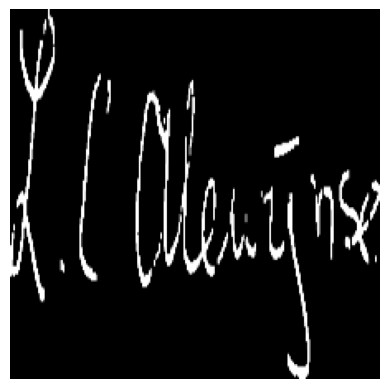

In [9]:
#test single image

from tensorflow.keras.preprocessing import image

img_path = "0108002_03.png"  

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

plt.imshow(img)
plt.axis('off')

pred = model.predict(x)[0][0]

if pred > 0.5:
    print("Prediction: Forged")
    print("Confidence:", round(pred*100,2), "%")
else:
    print("Prediction: Genuine")
    print("Confidence:", round((1-pred)*100,2), "%")
